# 1.このテキストについて

テキストの目的
- 実データに近いものに対して機械学習を行う

どのように学ぶか
- Kaggleのデータセットを通じて、機械学習の基本的な流れやライブラリの使い方を学びます。

# 【問題1】コンペティション内容の確認
コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。


- 何を学習し、何を予測するのか
- どのようなファイルを作りKaggleに提出するか
- 提出されたものはどういった指標値で評価されるのか

## 解答
- 何を学習し、何を予測するのか  

→ 顧客の取引情報を元にその顧客の返済能力を予測する。
- どのようなファイルを作りKaggleに提出するか  

→ カラム名SK_ID_CURRとTARGETからなるCSVファイルでTARGET列にはapplication_test.csvを元に予測した結果が入る。
- 提出されたものはどういった指標値で評価されるのか  

→ 提出物は、予測された確率と観測された目標の間のROC曲線の下の領域で評価される。

# 3.ベースラインモデルの作成

まずは単純な方法による ベースラインモデル　を作成します。精度の基準となるモデルです。


精度を高くする必要はありません。エラーなく実行でき、Kaggle側に推定値を提出できることを目指します。


# 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。


検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

In [2]:
# 警告非表示
import warnings
warnings.filterwarnings('ignore')

In [3]:
# データの読み込み
train = pd.read_csv('../Week3/application_train.csv')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### データ分析

In [4]:
# データの概要
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


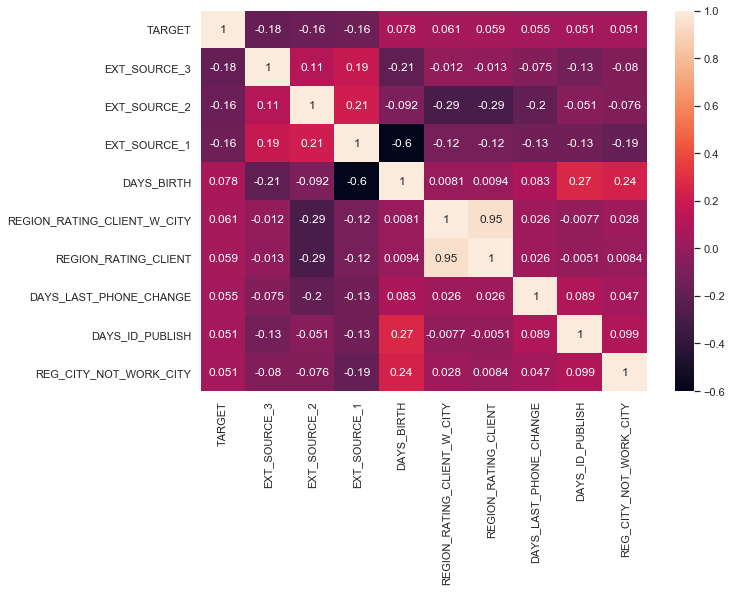

In [5]:
# 相関係数の確認
col = train.corr()['TARGET'].abs().nlargest(10).index.tolist()
train_top10 = train[col].corr()
plt.figure(figsize=(10,7))
sns.heatmap(train_top10, annot=True);

In [6]:
# 相関係数の高いトップ１０の基本統計量を確認
top10_data = train[col]
top10_data.describe()

,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY
count,307511.000000,246546.000000,3.068510e+05,134133.000000,307511.000000,307511.000000,307511.000000,307510.000000,307511.000000,307511.000000
mean,0.080729,0.510853,5.143927e-01,0.502130,-16036.995067,2.031521,2.052463,-962.858788,-2994.202373,0.230454
std,0.272419,0.194844,1.910602e-01,0.211062,4363.988632,0.502737,0.509034,826.808487,1509.450419,0.421124
min,0.000000,0.000527,8.173617e-08,0.014568,-25229.000000,1.000000,1.000000,-4292.000000,-7197.000000,0.000000
25%,0.000000,0.370650,3.924574e-01,0.334007,-19682.000000,2.000000,2.000000,-1570.000000,-4299.000000,0.000000
50%,0.000000,0.535276,5.659614e-01,0.505998,-15750.000000,2.000000,2.000000,-757.000000,-3254.000000,0.000000
75%,0.000000,0.669057,6.636171e-01,0.675053,-12413.000000,2.000000,2.000000,-274.000000,-1720.000000,0.000000
max,1.000000,0.896010,8.549997e-01,0.962693,-7489.000000,3.000000,3.000000,0.000000,0.000000,1.000000


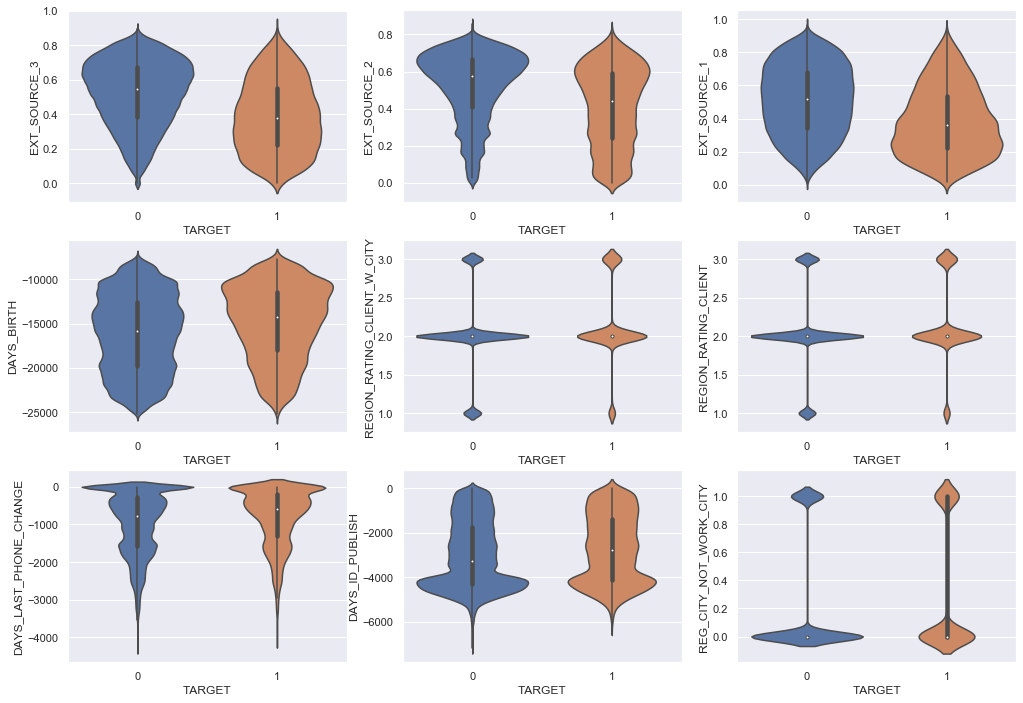

In [7]:
# バイオリン図描画
plt.figure(figsize=(17,12))
for i, colu in enumerate(top10_data.columns[1:]):
    plt.subplot(3,3,i+1)
    sns.violinplot(x='TARGET', y=colu, data=top10_data)

>相関係数が高いものは、確かに分布に差があるようだ。また、極端な外れ値もなさそう。

In [8]:
# 欠損値の確認
top10_data.isnull().sum().sort_values(ascending=False)

EXT_SOURCE_1                   173378
EXT_SOURCE_3                    60965
EXT_SOURCE_2                      660
DAYS_LAST_PHONE_CHANGE              1
REG_CITY_NOT_WORK_CITY              0
DAYS_ID_PUBLISH                     0
REGION_RATING_CLIENT                0
REGION_RATING_CLIENT_W_CITY         0
DAYS_BIRTH                          0
TARGET                              0
dtype: int64

### 前処理

In [9]:
# 欠損値を０で埋める
top10_data = top10_data.fillna(0)
top10_data.shape

(307511, 10)

In [10]:
# 訓練データ、検証データに分割
from sklearn.model_selection import train_test_split

X = top10_data.iloc[:, 1:]
y = top10_data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### 学習・推定

In [11]:
# ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

# 学習
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# 推定
rf_pred = rf.predict_proba(X_test)[:, 1]

In [12]:
# ロジスティック回帰
from sklearn.linear_model import LogisticRegression

# 学習
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

# 推定
lr_pred = lr.predict_proba(X_test)[:, 1]

### 評価

In [13]:
# ROCを求める
from sklearn.metrics import roc_auc_score

print(f'ランダムフォレスト: {roc_auc_score(y_test, rf_pred)}')
print(f'ロジスティック回帰: {roc_auc_score(y_test, lr_pred)}')

ランダムフォレスト: 0.6988308941661003
ロジスティック回帰: 0.599241904494924


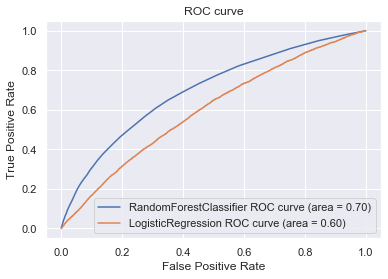

In [14]:
# ROC曲線とAUCの出力
from sklearn import metrics

# FPR, TPR(, しきい値) を算出
fpr , tpr , thresholds = metrics.roc_curve(y_test , rf_pred)
fpr1 , tpr1 , thresholds = metrics.roc_curve(y_test , lr_pred)

# AUC
auc = metrics.auc(fpr, tpr)
auc1 = metrics.auc(fpr1, tpr1)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='RandomForestClassifier ROC curve (area = %.2f)'%auc)
plt.plot(fpr1, tpr1, label='LogisticRegression ROC curve (area = %.2f)'%auc1)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

EXT_SOURCE_2                   0.207909
DAYS_BIRTH                     0.186776
DAYS_ID_PUBLISH                0.179929
DAYS_LAST_PHONE_CHANGE         0.157335
EXT_SOURCE_3                   0.140492
EXT_SOURCE_1                   0.086850
REG_CITY_NOT_WORK_CITY         0.014512
REGION_RATING_CLIENT_W_CITY    0.013225
REGION_RATING_CLIENT           0.012971
dtype: float64


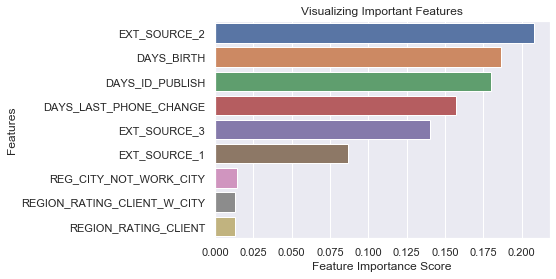

In [15]:
# ランダムフォレストの各特徴量の重要度の計算
feature_imp = pd.Series(rf.feature_importances_,index=col[1:]).sort_values(ascending=False)
print(feature_imp)

# 図の描画
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features');

# 【問題3】テストデータに対する推定
テストデータ（application_test.csv）に対して推定を行い、Kaggleに提出を行ってください。


正しく提出が行えていれば、精度は低くても構いません。

In [16]:
# テストデータ読み込み
test = pd.read_csv('application_test.csv')

In [17]:
# 特徴量選択
test_data = test[col[1:]]
test_data.shape

(48744, 9)

In [18]:
# 欠損値確認
test_data.isnull().sum()

EXT_SOURCE_3                    8668
EXT_SOURCE_2                       8
EXT_SOURCE_1                   20532
DAYS_BIRTH                         0
REGION_RATING_CLIENT_W_CITY        0
REGION_RATING_CLIENT               0
DAYS_LAST_PHONE_CHANGE             0
DAYS_ID_PUBLISH                    0
REG_CITY_NOT_WORK_CITY             0
dtype: int64

In [19]:
# 欠損値0埋め
test_data = test_data.fillna(0)

# 推定
test_pred = rf.predict_proba(test_data)[:, 1]

In [20]:
# 提出用ファイルの作成
submission =pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': test_pred})
submission.to_csv('submission_HomeCredit1.csv', index=False)

In [21]:
pd.read_csv('submission_HomeCredit1.csv').head()

,SK_ID_CURR,TARGET
0,100001,0.04
1,100005,0.05
2,100013,0.02
3,100028,0.02
4,100038,0.14


![画像](https://gyazo.com/cf2f98a7093048704c80e11af2795416.gng)

# 4.特徴量エンジニアリング

ベースラインモデルを元に、入力する特徴量に様々な工夫を行い精度を向上させていきます。

# 【問題4】特徴量エンジニアリング
精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。


- どの特徴量を使うか
- どう前処理をするか

何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。


精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

## ＜方針＞
- 問題２から、精度のよかったランダムフォレストを学習器として用いる。
- 今回は特徴量の重みのみに焦点を置く為、ハイパーパラメータの調整は行わない。

## ＜選んだ特徴量＞  
- パターン1 ー 問題2から重要度の高い特徴量6個。
- パターン2 ー カテゴリ変数をラベル化して相関係数が高かった4個
- パターン3 ー パターン2の特徴量をダミー変数化
- パターン4 ー 問題2とパターン2で使った特徴量
- パターン5 ー パターン４の特徴量と仮説を元にした特徴量

## ＜前処理＞
- 欠損値について、0埋め、削除、平均値埋め、中央値埋め、最頻値埋めと試した結果、大差なかったため今回は0埋めを採用する。  
- ランダムフォレストを用いるため標準化は行わない。

In [22]:
train = pd.read_csv('../Week3/application_train.csv')

# パターン１ 
### 問題２で重要度の低かった特徴量はノイズになる可能性があると考え、低いものを削除して検証する。

In [23]:
# 特徴量の抽出
imp_col = ['TARGET', 'EXT_SOURCE_2','DAYS_BIRTH', 'DAYS_ID_PUBLISH',
           'DAYS_LAST_PHONE_CHANGE', 'EXT_SOURCE_3', 'EXT_SOURCE_1']

train_1 = train[imp_col]
train_1.head()

,TARGET,EXT_SOURCE_2,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,EXT_SOURCE_3,EXT_SOURCE_1
0,1,0.262949,-9461,-2120,-1134.0,0.139376,0.083037
1,0,0.622246,-16765,-291,-828.0,NaN,0.311267
2,0,0.555912,-19046,-2531,-815.0,0.729567,NaN
3,0,0.650442,-19005,-2437,-617.0,NaN,NaN
4,0,0.322738,-19932,-3458,-1106.0,NaN,NaN


In [24]:
# 欠損値の０埋め
train_1 = train_1.fillna(0)

# 分割
X = train_1.iloc[:, 1:]
y = train_1['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 学習
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [25]:
# 推定
rf_pred = rf.predict_proba(X_test)[:, 1]

# 評価
pred_1 = roc_auc_score(y_test, rf_pred)
pred_1

0.6946184712519471

問題２のROC：0.6988 → 0.6946

>重要度が低い特徴量を減らしたことでわずかに精度が下がった。

# パターン2
### ここまでは数値データの相関係数のみに着目してきたが、カテゴリ変数に使えるものがないか探す。

In [26]:
categorical_variable_col = list(train.select_dtypes(include=object).columns)
categorical_variable_col

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [27]:
for i in categorical_variable_col:
    print('ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー')
    print(i)
    print(train[i].value_counts())

ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー
NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64
ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー
CODE_GENDER
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー
FLAG_OWN_CAR
N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64
ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー
FLAG_OWN_REALTY
Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64
ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー
NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64
ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー
NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman      

### ラベル化

In [28]:
# カテゴリ変数の抽出
train_2 = train[categorical_variable_col]
train_2 = pd.concat([train[['TARGET']], train_2], axis=1)

# 欠損値を'Na'とする
train_2 = train_2.fillna('Na')

In [29]:
# ラベルエンコード
from sklearn.preprocessing import LabelEncoder

for col_cat in categorical_variable_col:
    lbl = LabelEncoder()
    train_2[col_cat] = lbl.fit_transform(train_2[col_cat].values)

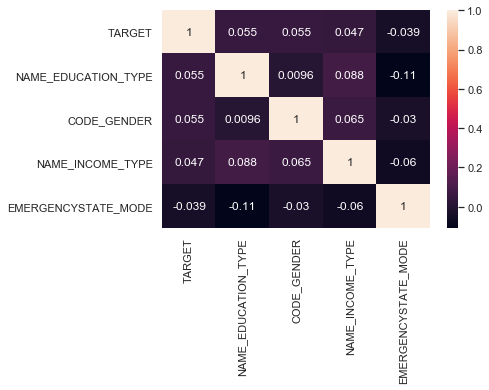

In [30]:
# 相関高い4つを抽出
cat_top5 = train_2.corr().abs()['TARGET'].nlargest(5).index
train_2 = train_2[cat_top5]
sns.heatmap(train_2.corr(), annot=True);

In [31]:
train_2.head()

,TARGET,NAME_EDUCATION_TYPE,CODE_GENDER,NAME_INCOME_TYPE,EMERGENCYSTATE_MODE
0,1,4,1,7,1
1,0,1,0,4,1
2,0,4,1,7,0
3,0,4,0,7,0
4,0,4,1,7,0


In [32]:
# 分割
X = train_2.iloc[:, 1:]
y = train_2['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 学習
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [33]:
# 推定
rf_pred = rf.predict_proba(X_test)[:, 1]

# 評価
pred_2 = roc_auc_score(y_test, rf_pred)
pred_2

0.6069736746827598

>カテゴリ変数に絞ってもスコアは低いが予測はできている。

# パターン３
### ダミー変数化で差がでるか？

In [34]:
train_3 = train[cat_top5]

In [35]:
# ダミー変数化
train_3 = pd.get_dummies(train_3, drop_first=True)
train_3.shape

(307511, 15)

In [36]:
train_3.head()

,TARGET,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,CODE_GENDER_M,CODE_GENDER_XNA,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,EMERGENCYSTATE_MODE_Yes
0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0


In [37]:
# 分割
X = train_3.iloc[:, 1:]
y = train_3['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 学習
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [38]:
# 推定
rf_pred = rf.predict_proba(X_test)[:, 1]

# 評価
pred_3 = roc_auc_score(y_test, rf_pred)
pred_3

0.6007506843973803

>差はない。

# パターン４
### 問題２とパターン２の特徴量を結合

In [39]:
# 問題２の特徴量とパターン２の特徴量を結合
train_4 = pd.concat([top10_data, train_2.iloc[:, 1:]], axis=1)
train_4.shape

(307511, 14)

In [40]:
# 分割
X = train_4.iloc[:, 1:]
y = train_4['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 学習
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [41]:
# 推定
rf_pred = rf.predict_proba(X_test)[:, 1]

# 評価
pred_4 = roc_auc_score(y_test, rf_pred)
pred_4

0.7060297193397002

問題2のROC：0.6988 → 0.706
>わずかながら精度向上。

EXT_SOURCE_2                   0.189093
DAYS_BIRTH                     0.168530
DAYS_ID_PUBLISH                0.164045
DAYS_LAST_PHONE_CHANGE         0.145193
EXT_SOURCE_3                   0.138317
EXT_SOURCE_1                   0.082758
EMERGENCYSTATE_MODE            0.021764
NAME_INCOME_TYPE               0.021172
NAME_EDUCATION_TYPE            0.016832
REG_CITY_NOT_WORK_CITY         0.014409
CODE_GENDER                    0.013381
REGION_RATING_CLIENT_W_CITY    0.012285
REGION_RATING_CLIENT           0.012221
dtype: float64


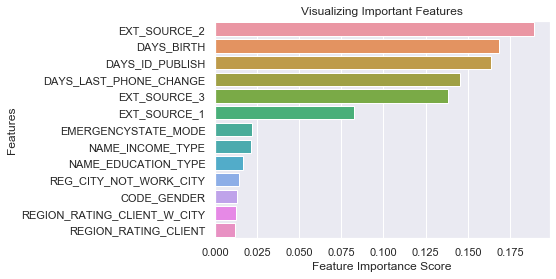

In [42]:
# ランダムフォレストの各特徴量の重要度の計算
feature_imp = pd.Series(rf.feature_importances_,index=train_4.columns[1:]).sort_values(ascending=False)
print(feature_imp)

# 図の描画
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features');

>相関係数を手掛かりに特徴量を抽出してきたが、EXT_SOURCE_1の重要度を下回る特徴量は誤差程度にしか精度に影響していない。それ以外で有効な特徴量を探す必要がある。

# パターン５
### 仮説を元に特徴量を抽出
- AMT_CREDIT：ローンの額が多いほど返済が大変そう。
- AMT_ANNUITY：月々の返済額が多いほど返済が大変そう。
- DAYS_EMPLOYED：転職直後だと生活が不安定そう。
- AMT_GOODS_PRICE：ローンが適応される商品が高いほど返済が大変そう。

In [43]:
# 仮説のカラム名リスト
hypothesis_col = ['AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'AMT_GOODS_PRICE']

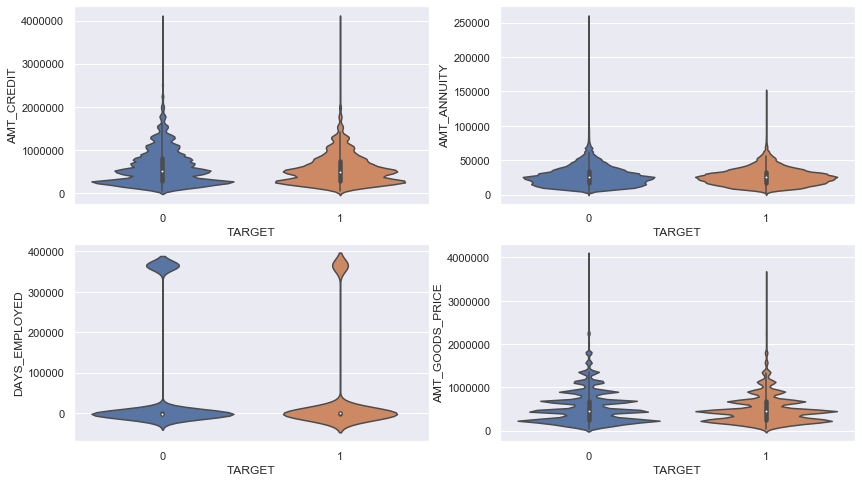

In [44]:
# バイオリン図描画
plt.figure(figsize=(14,8))
for i, colu in enumerate(train[hypothesis_col].columns):
    plt.subplot(2,2,i+1)
    sns.violinplot(x='TARGET', y=colu, data=train)

>分布の差はありそう。

In [45]:
# 特徴量抽出と欠損値０埋め
train_5 = train[hypothesis_col].fillna(0)
train_5 = pd.concat([top10_data, train_5, train_2.iloc[:, 1:]], axis=1)

In [46]:
# 特徴量に返済期間を追加
train_5['CREDIT_TERM'] = train_5['AMT_ANNUITY'] / train_5['AMT_CREDIT']
train_5.shape

(307511, 19)

In [47]:
train_5.head()

,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,CODE_GENDER,NAME_INCOME_TYPE,EMERGENCYSTATE_MODE,CREDIT_TERM
0,1,0.139376,0.262949,0.083037,-9461,2,2,-1134.0,-2120,0,406597.5,24700.5,-637,351000.0,4,1,7,1,0.060749
1,0,0.000000,0.622246,0.311267,-16765,1,1,-828.0,-291,0,1293502.5,35698.5,-1188,1129500.0,1,0,4,1,0.027598
2,0,0.729567,0.555912,0.000000,-19046,2,2,-815.0,-2531,0,135000.0,6750.0,-225,135000.0,4,1,7,0,0.050000
3,0,0.000000,0.650442,0.000000,-19005,2,2,-617.0,-2437,0,312682.5,29686.5,-3039,297000.0,4,0,7,0,0.094941
4,0,0.000000,0.322738,0.000000,-19932,2,2,-1106.0,-3458,1,513000.0,21865.5,-3038,513000.0,4,1,7,0,0.042623


In [48]:
# 分割
X = train_5.iloc[:, 1:]
y = train_5['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 学習
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [49]:
# 推定
rf_pred = rf.predict_proba(X_test)[:, 1]

# 評価
pred_5 = roc_auc_score(y_test, rf_pred)
pred_5

0.7234603644676263

EXT_SOURCE_2                   0.119043
DAYS_BIRTH                     0.096861
DAYS_ID_PUBLISH                0.094172
EXT_SOURCE_3                   0.090914
CREDIT_TERM                    0.086216
DAYS_EMPLOYED                  0.083768
DAYS_LAST_PHONE_CHANGE         0.082431
AMT_ANNUITY                    0.082078
AMT_CREDIT                     0.071310
AMT_GOODS_PRICE                0.057424
EXT_SOURCE_1                   0.051325
EMERGENCYSTATE_MODE            0.015235
NAME_INCOME_TYPE               0.013770
NAME_EDUCATION_TYPE            0.012219
REGION_RATING_CLIENT_W_CITY    0.011111
REGION_RATING_CLIENT           0.011104
REG_CITY_NOT_WORK_CITY         0.010813
CODE_GENDER                    0.010205
dtype: float64


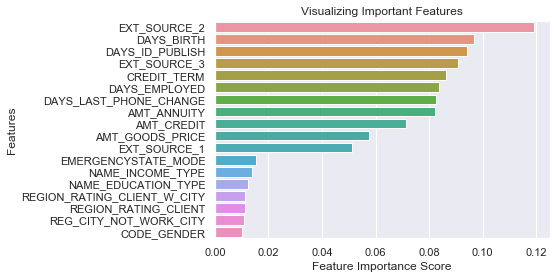

In [50]:
# ランダムフォレストの各特徴量の重要度の計算
feature_imp = pd.Series(rf.feature_importances_,index=train_5.columns[1:]).sort_values(ascending=False)
print(feature_imp)

# 図の描画
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features');

>全パターンで最高スコアであった。仮説を元に追加した特徴量も機能している。

# 提出ファイル作成
### パターン５のモデルを使ってテストデータを予測する。

In [51]:
test = pd.read_csv('application_test.csv')

In [52]:
# 全データでモデル作成
model = RandomForestClassifier(random_state=0)
model.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [53]:
# 特徴量抽出
lis = X.columns.tolist()
lis.remove('CREDIT_TERM')
test_data2 = test[lis]

In [54]:
# 欠損値処理
obc = []
for i in lis:
    if test_data2[i].dtype=='O':
        obc.append(i)
        test_data2[i] = test_data2[i].fillna('na')
    else:
        test_data2[i] = test_data2[i].fillna(0)

In [55]:
# ラベルエンコーディング
for col_cat in obc:
    lbl = LabelEncoder()
    test_data2[col_cat] = lbl.fit_transform(test_data2[col_cat].values)

In [56]:
# CREDIT_TERM追加
test_data2['CREDIT_TERM'] = test_data2['AMT_ANNUITY'] / test_data2['AMT_CREDIT']
test_data2.shape

(48744, 18)

In [57]:
# 推定
pred = model.predict_proba(test_data2)[:, 1]

In [58]:
# 提出用ファイルの作成
submission2 =pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': pred})
submission2.to_csv('submission_HomeCredit2.csv', index=False)

In [59]:
pd.read_csv('submission_HomeCredit2.csv').head()

,SK_ID_CURR,TARGET
0,100001,0.07
1,100005,0.11
2,100013,0.06
3,100028,0.08
4,100038,0.19


![画像](https://gyazo.com/bf5a2e741d578481b377a0a1a3aaf52d.gng)

>手元の評価値との乖離も小さく、うまく学習できている。

### ＜考察＞
- 目的変数との相関係数のみでは、特徴量の重要度を量りきれていないことに気付き、特徴量エンジニアリングの大切さを知った。
- 異なる特徴量を組み合わせることによって、新たな特徴量が作れることを知った。しかし、EXT_SOURCE系を足し合わせたものでは精度が落ちたため今回は採用しなかったが、多重共線性？になるかならないかの判断が難しいと思った。
- よりすぐった特徴量に絞る方が精度が出やすいと考えていたが、重要度が低めな特徴量でも精度に貢献していたのが意外であった。
- 今回は欠損値の最適な処理を見出せなかったので、今後習得したい。
- 提出ファイル作成でハマったこととして、fit時のカラムの並び順とpredict_proba時のカラムの並び順が同順でなければならないことを知った。テストデータの前処理が複雑になる際は気をつけたい。